In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2
import pandas as pd
import numpy as np
import os

In [2]:
#model = load_model('animal_init_graph_model_success.h5')


In [3]:
translate = {"cane": "Dog", "cavallo": "Horse", "elefante": "Elephant", "farfalla": "Butterfly", "gallina": "Chicken", "gatto": "Cat", "mucca": "Cow", "pecora": "Sheep", "scoiattolo": "Squirrel", "ragno": "Spider", "buffalo":"buffalo", "rhino":"rhino", "zebra":"zebra", "Crab":"Crab", "Deer":"Deer", "Eagle":"Eagle", "Fox":"Fox", "Frog":"Frog", "Giraffe":"Giraffe", "Jellyfish":"Jellyfish", "Lion":"Lion", "Lizard":"Lizard", "Monkey":"Monkey", "Owl":"Owl", "Parrot":"Parrot", "Penguin":"Penguin", "Pig":"Pig", "Polar bear":"Polar bear", "Rabbit":"Rabbit", "Sea lion":"Sea lion", "Sea turtle":"Sea turtle", "Shark":"Shark", "Tiger":"Tiger", "Whale":"Whale"}

In [14]:
#####
#####舊資料前處理
#####
foldernames = os.listdir("D:/CODE/school_project/raw-img/")

x_train, y_train, x_test, y_test = [], [], [], []

for i,folder in enumerate(foldernames):
    filenames = os.listdir("D:/CODE/school_project/raw-img/" + folder)
    count = 0
    for file in filenames:
        if count < 200:
            x_train.append("D:/CODE/school_project/raw-img/" + folder + "/" + file)
            x_test.append(translate[folder])
        else:
            y_train.append("D:/CODE/school_project/raw-img/" + folder + "/" + file)
            y_test.append(translate[folder])
        count+=1
df_x = pd.DataFrame({'Filepath':x_train, 'Target':x_test})
df_y = pd.DataFrame({'Filepath':y_train, 'Target':y_test})
train, test = train_test_split(df_x, test_size=0.3, random_state = 0)

In [64]:
#from keras.preprocessing.image import load_img
from keras.preprocessing import image
foldernames = os.listdir("D:/CODE/school_project/raw-img/")

data_x, data_y = [], []
x_train, y_train, x_test, y_test = [], [], [], []

for i,folder in enumerate(foldernames):
    filenames = os.listdir("D:/CODE/school_project/raw-img/" + folder)
    for file in filenames:
        #print("D:/CODE/school_project/raw-img/" + folder + "/" + file)
        #img = image.load_img("D:/CODE/school_project/raw-img/{}/{}".format(folder,file))
        #print(type(img))
        
        data_x.append("D:/CODE/school_project/raw-img/" + folder + "/" + file)
        data_y.append(translate[folder])

x_train, y_train, x_test, y_test = train_test_split(data_x,data_y, test_size=0.3, random_state = 0)
df_x = pd.DataFrame({'Filepath':x_train, 'Target':x_test})
df_y = pd.DataFrame({'Filepath':y_train, 'Target':y_test})
train, test = train_test_split(df_x, test_size=0.3, random_state = 0)

In [65]:
min_count = 10000
for dirname, _, filenames in os.walk('D:/CODE/school_project/raw-img/'):
    dirs = dirname.split("/")
    last = dirs[len(dirs) - 1]
    count = 0
    
    if last in translate.keys():
        for filename in filenames:
            count += 1
        if count < min_count:
            min_count = count
            
print(f"Min count: {min_count}")

Min count: 217


In [66]:
print(train.shape)
print(test.shape)
    
print("-----------------------------------------------------------")

print(len(x_train))
print(len(y_train))

print("-----------------------------------------------------------")

print(len(x_test))
print(len(y_test))

(17924, 2)
(7682, 2)
-----------------------------------------------------------
25606
10974
-----------------------------------------------------------
25606
10974


In [67]:
datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center = True,
        )
datagen_test = ImageDataGenerator(rescale=1./255,samplewise_center = True)


In [84]:
train_flow = datagen.flow_from_dataframe(train, 
                                         x_col = 'Filepath', 
                                         y_col = 'Target', 
                                         target_size=(100, 100), 
                                         interpolation = 'lanczos', 
                                         shuffle=False,#True, ###繪製confusion_matrix時,需將shuffle關閉
                                         validate_filenames = False)
test_flow = datagen_test.flow_from_dataframe(test, 
                                             x_col = 'Filepath', 
                                             y_col = 'Target', 
                                             target_size=(100, 100), 
                                             shuffle=False,#True, ###繪製confusion_matrix時,需將shuffle關閉
                                             interpolation = 'lanczos', 
                                             validate_filenames = False)

Found 17924 non-validated image filenames belonging to 32 classes.
Found 7682 non-validated image filenames belonging to 32 classes.


In [77]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [78]:
#model = applications.VGG16(weights='imagenet', include_top = False, input_shape=(100, 100, 3))
model = ResNet50(weights='imagenet', include_top = False, input_shape=(100, 100, 3))

flat1 = tf.keras.layers.Flatten()(model.output)
dropout1 = Dropout(0.1)(flat1)
class1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.1)(class1)
output = tf.keras.layers.Dense(32, activation='softmax')(dropout2)
model = Model(inputs = model.inputs, outputs = output)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(learning_rate=1e-3, momentum=0.9), metrics = ['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [79]:
#VGG16.model
#ResNet50.model
history = model.fit(train_flow, 
                              epochs = 10, 
                              validation_data = test_flow, 
                              callbacks=[ModelCheckpoint('ResNet50.model', monitor='val_acc'), reduce_lr])

Epoch 1/10
561/561 [==============================] - 150s 261ms/step - loss: 1.5004 - accuracy: 0.5946 - val_loss: 4.0643 - val_accuracy: 0.1302


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets
Epoch 2/10
561/561 [==============================] - 145s 259ms/step - loss: 0.8752 - accuracy: 0.7426 - val_loss: 0.9010 - val_accuracy: 0.7416


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets
Epoch 3/10
561/561 [==============================] - 151s 270ms/step - loss: 0.6874 - accuracy: 0.7963 - val_loss: 0.7474 - val_accuracy: 0.7995


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets
Epoch 4/10
561/561 [==============================] - 155s 276ms/step - loss: 0.5722 - accuracy: 0.8249 - val_loss: 0.8204 - val_accuracy: 0.7908


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/10
561/561 [==============================] - 157s 279ms/step - loss: 0.4050 - accuracy: 0.8758 - val_loss: 0.6061 - val_accuracy: 0.8390


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets
Epoch 6/10
561/561 [==============================] - 164s 292ms/step - loss: 0.3471 - accuracy: 0.8893 - val_loss: 0.6286 - val_accuracy: 0.8394


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 7/10
561/561 [==============================] - 145s 258ms/step - loss: 0.3230 - accuracy: 0.8976 - val_loss: 0.6103 - val_accuracy: 0.8454


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets

Epoch 00007: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 8/10
561/561 [==============================] - 145s 259ms/step - loss: 0.2987 - accuracy: 0.9074 - val_loss: 0.6080 - val_accuracy: 0.8464


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 9/10
561/561 [==============================] - 145s 258ms/step - loss: 0.3002 - accuracy: 0.9074 - val_loss: 0.6080 - val_accuracy: 0.8457


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets

Epoch 00009: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 10/10
561/561 [==============================] - 150s 268ms/step - loss: 0.3120 - accuracy: 0.9019 - val_loss: 0.6078 - val_accuracy: 0.8460


c:\users\will_liao\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ResNet50.model\assets

Epoch 00010: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.


In [83]:
#model.save("vgg16cls32ac8343.h5")
#model.save("resnet50cls32ac8342.h5")

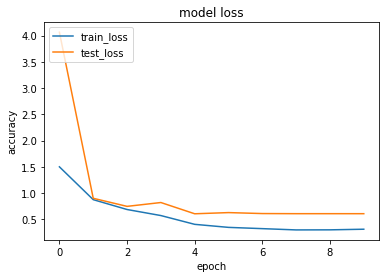

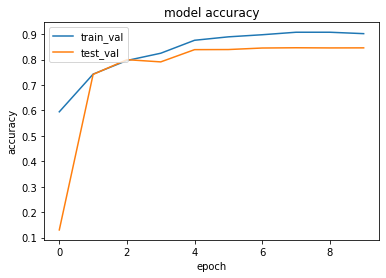

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss','test_loss'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_val','test_val'], loc='upper left')
plt.show()

In [81]:
show_flow = datagen_test.flow_from_dataframe(df_y, 
                                             x_col = 'Filepath', 
                                              y_col = 'Target', 
                                              target_size=(100, 100), 
                                              interpolation = 'lanczos', 
                                              validate_filenames = False)
score = model.evaluate(show_flow)

Found 10974 non-validated image filenames belonging to 32 classes.
343/343 [==============================] - 48s 139ms/step - loss: 0.6527 - accuracy: 0.8342


In [203]:
images = []
for i, labelname in enumerate(os.listdir("D:/CODE/pre_img")):
    temp = np.array(tf.keras.preprocessing.image.load_img( 'D:/CODE/pre_img/' + labelname, 
                                                          color_mode = "rgb", 
                                                          target_size = (100, 100), 
                                                          interpolation="lanczos")) / 255.0
    images.append(temp)
images = np.array(images)

In [204]:
predictions = model.predict(images)
pred_ints = predictions.argmax(axis = -1)
out = []
for x in pred_ints:
    labels = train_flow.class_indices
    for label, val in labels.items():
        if val == x:
            out.append(label)

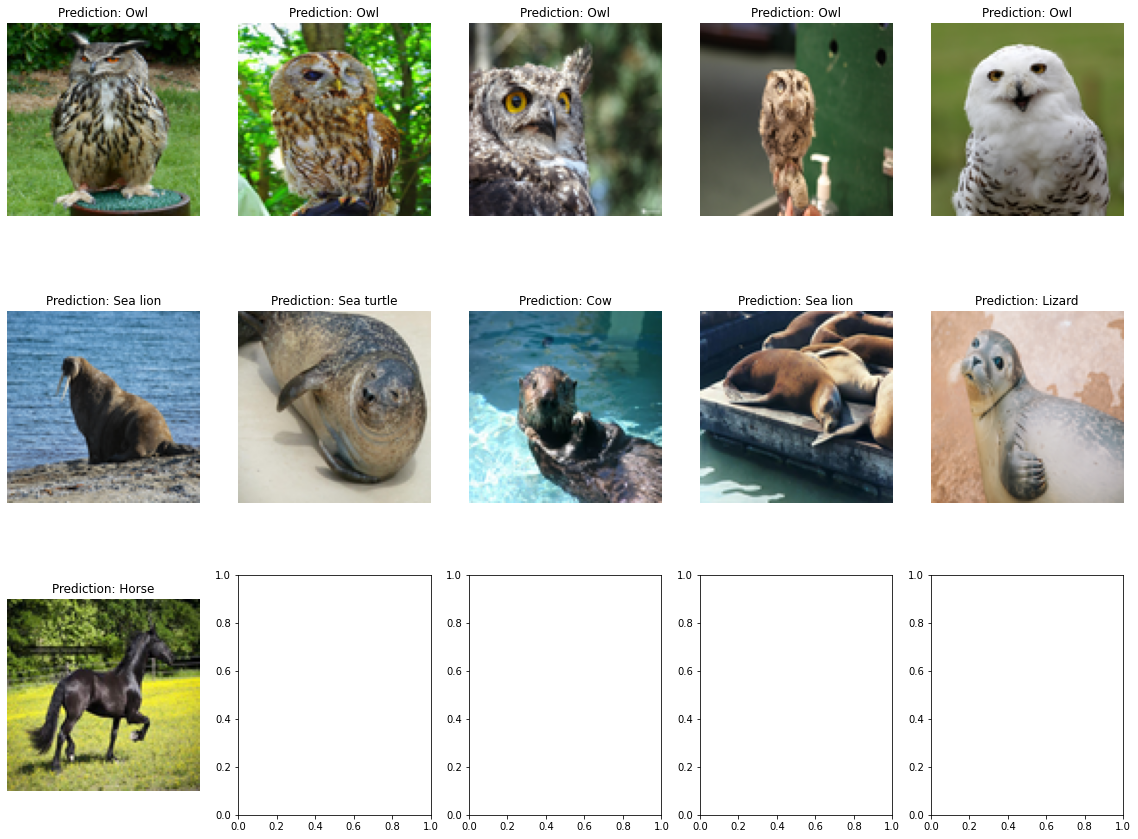

In [205]:
rows,cols = ((len(images) - 1) // 5 ) + 1,5
temp_axis = rows * 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,temp_axis))
for i in range(len(images)):
    temp = 'Prediction: ' + out[i]
    axes[i//cols, i%cols].set_title(temp)
    axes[i//cols, i%cols].axis('off')
    axes[i//cols, i%cols].imshow(images[i])
#fig.savefig('New_Images_Prediction.eps', format='eps')

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#import seaborn as sns

num_of_train_samples = 17924#21103 #9800
num_of_test_samples = 7682 #4200
batch_size = 32 #flow_from_dataframe預設batch_size為32  參考:https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

Y_pred = model.predict(test_flow,num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
#print(confusion_matrix(test_flow.classes, y_pred))
cnf_matrix = confusion_matrix(test_flow.classes, y_pred)
#print('Classification Report')
target_names = ["Dog", "Horse", "Elephant", "Butterfly", "Chicken", "Cat", "Cow", "Sheep", "Squirrel", "Spider", "buffalo", "rhino", "zebra", "Deer", "Eagle", "Fox", "Frog", "Giraffe", "Jellyfish", "Lion", "Lizard", "Monkey", "Owl", "Parrot", "Penguin", "Polar bear", "Rabbit", "Sea lion", "Sea turtle", "Shark", "Tiger", "Whale"]
print(classification_report(test_flow.classes, y_pred, target_names=target_names))

plt.figure()
#plot_confusion_matrix(cnf_matrix, labels=target_names,normalize=True)
#plot_confusion_matrix(X = test_flow.classes, y_true = y_pred,labels= target_names, normalize=False)
f = sns.heatmap(cnf_matrix, annot=True) #參考:https://stackoverflow.com/questions/60776749/plot-confusion-matrix-without-estimator

Confusion Matrix
              precision    recall  f1-score   support

         Dog       0.84      0.95      0.89       452
       Horse       0.88      0.85      0.86       341
    Elephant       0.85      0.95      0.90       668
   Butterfly       0.79      0.87      0.82       402
     Chicken       0.71      0.54      0.61        97
         Cat       0.88      0.86      0.87      1055
         Cow       0.86      0.87      0.86       177
       Sheep       0.83      0.90      0.86       296
    Squirrel       0.90      0.51      0.65        51
      Spider       0.78      0.57      0.66       145
     buffalo       0.83      0.65      0.73        62
       rhino       0.86      0.90      0.88       520
       zebra       0.95      0.94      0.94       113
        Deer       0.87      0.75      0.80        60
       Eagle       0.71      0.75      0.73       257
         Fox       0.82      0.44      0.57       150
        Frog       0.78      0.61      0.68       114
     Giraf

NameError: name 'sns' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
, "buffalo", "rhino", "zebra", "Bear", "Crab", "Deer", "Eagle", "Fox", "Frog", "Giraffe", "Goose", "Harbor seal", "Jellyfish", "Lion", "Lizard", "Monkey", "Mouse", "Owl", "Parrot", "Penguin", "Pig", "Polar bear", "Rabbit", "Sea lion", "Sea turtle", "Shark", "Tiger", "Whale"